In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import optimize

In [2]:
coolpath = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
assembly = 'hg19'
cell_line = 'GM12878'
c = cooler.Cooler(coolpath + '::/resolutions/100000')

In [3]:
bins = c.bins()[:]
loc_eig= bins[bins['chrom'] == 'chr19']
mask = loc_eig['weight'] == loc_eig['weight']

In [4]:
chrom_size = len(loc_eig[loc_eig['weight'] == loc_eig['weight']])

In [5]:
arr = c.matrix(balance=True)[loc_eig.index[0]:loc_eig.index[-1] + 1, loc_eig.index[0]:loc_eig.index[-1] + 1]


In [6]:
chrom_size

548

In [7]:
arr = arr[~np.isnan(arr)].reshape(chrom_size, chrom_size)

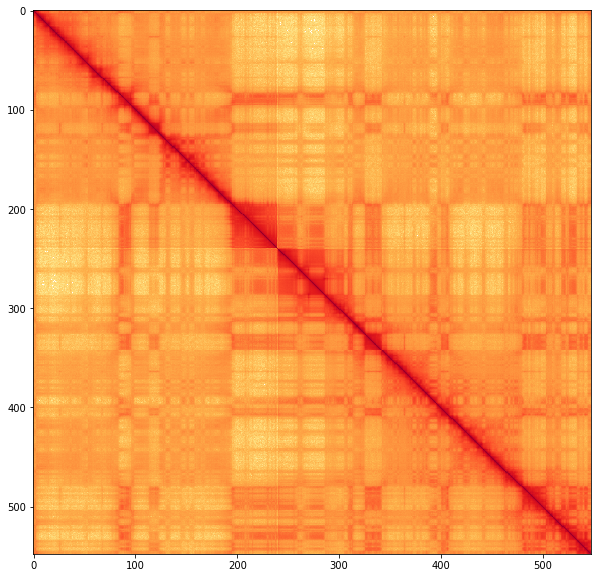

In [8]:
fig = plt.figure(2, figsize=(10, 10)) 
plt.imshow(arr
                ,aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-6, vmax=np.nanmax(arr)))

In [9]:
def correction(M):
    W = M
    B = np.ones((len(M),1))
    for i in range(200):
        S = np.sum(W, axis = 1, keepdims = True)
        del_B = S/np.mean(S, keepdims = True)
        mat_B = np.dot(del_B, del_B.T)
        W = W/mat_B
        B = B*del_B
    return W, B

In [10]:
W, B = correction((arr+0.0001))
s = np.sum(W, axis =1)
s

array([0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585523,
       0.98585523, 0.98585523, 0.98585523, 0.98585523, 0.98585

In [11]:
W = W/s

## Bias and corrected matrix 

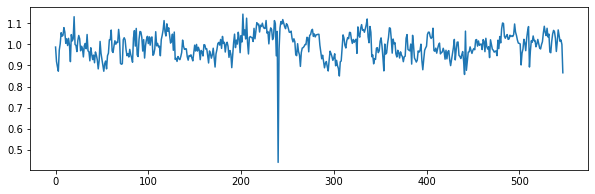

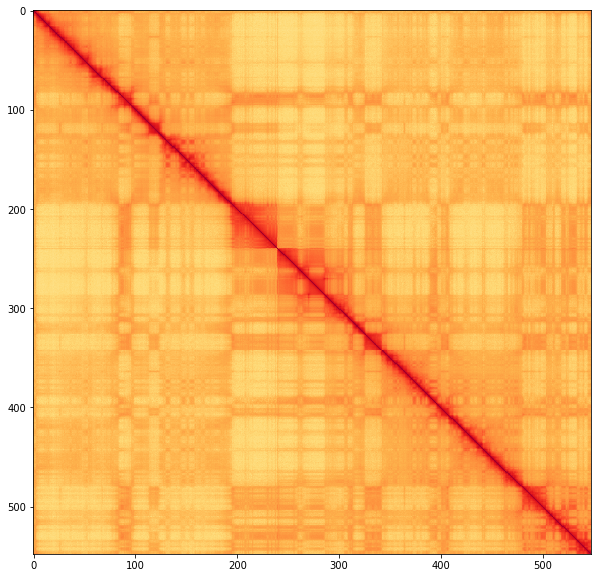

In [12]:
plt.figure(1, figsize = (10, 3))
plt.plot(B)
plt.figure(2, figsize = (10, 10))
plt.imshow(W
                ,aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-5, vmax=np.nanmax(W)))

In [13]:
def get_cdp(M):
    P = np.zeros(len(M))
    for k in range(len(M)):
        for i in range(len(M)-k):
            P[k] += M[i, i-k]
    return P/np.sum(P)

In [14]:
P = get_cdp(W)

In [15]:
def test_func(x, a, b):
    return (a*(x**b))

In [16]:
offset = 100
last = 50
x = np.linspace(offset+1, len(W)-last, len(W)-offset-last)
params1, params_covariance = optimize.curve_fit(test_func, x, P[offset:len(W)-last])
p1 = test_func(x, *params1)
params1

array([ 0.05908406, -0.9491291 ])

## We can observe that some regions in the genome have higher contacts than expected, some others have lower. We expect these regions to be our compartments. 

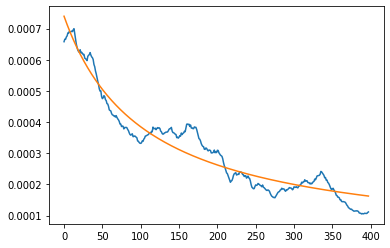

In [17]:
plt.plot(P[offset:len(W)-last])
plt.plot(p1[:])

In [18]:
F = np.arange(len(W))
Z = np.abs(F[None, :]-F[:, None])
M = test_func(Z+1, *params1)

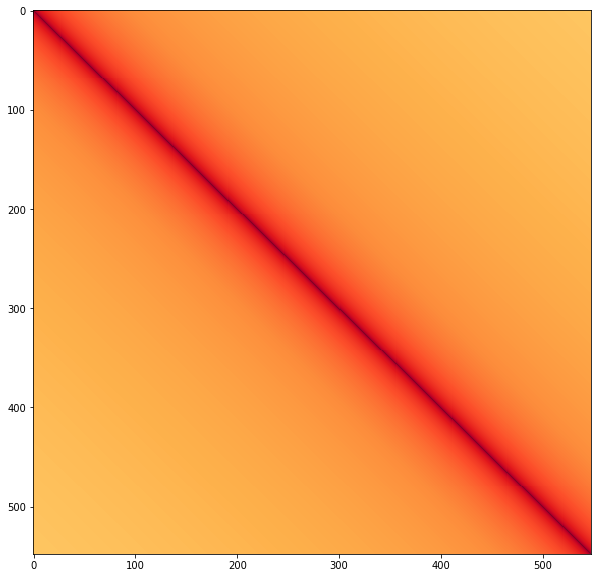

In [19]:
plt.figure(2, figsize = (10, 10))
plt.imshow(M
                ,aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-5, vmax=np.nanmax(M)))

In [20]:
enrich = np.log(W/M)

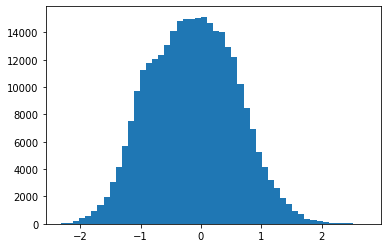

In [21]:
plt.hist(enrich.reshape(-1,1), bins = 50);

# log(Observed/Expected)

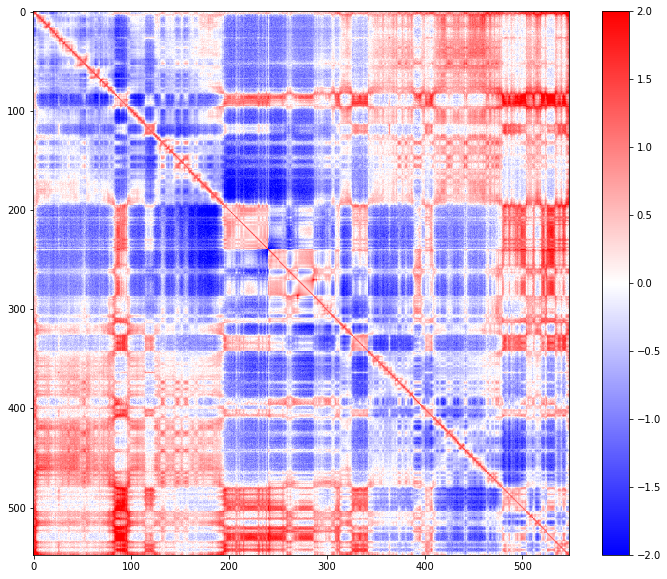

In [22]:
plt.figure(3, figsize = (12, 10))
plt.imshow(enrich
                ,aspect='auto',cmap='bwr'
              ,interpolation='None', vmin = -2, vmax = 2)
plt.colorbar();

In [23]:
[S, E] = np.linalg.eig(np.log(W/M))

In [24]:
np.round(S/np.sum(np.abs(S)), 5)[0:10]

array([ 0.10689, -0.09434, -0.06287,  0.04534,  0.04028,  0.02128,
       -0.01463,  0.01438,  0.01233,  0.01182])

In [25]:
U = S*E

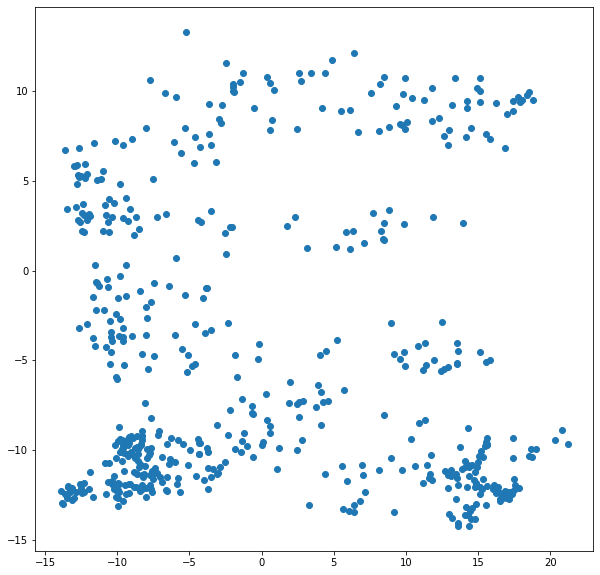

In [26]:
plt.figure(4, figsize = (10, 10))
plt.scatter(U[:, 0], U[:, 1])

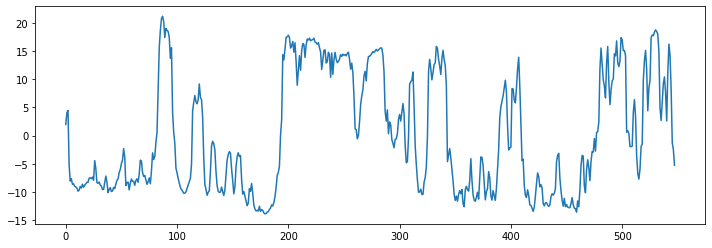

In [27]:
plt.figure(0, figsize = (12, 4))
plt.plot(U[:, 0])

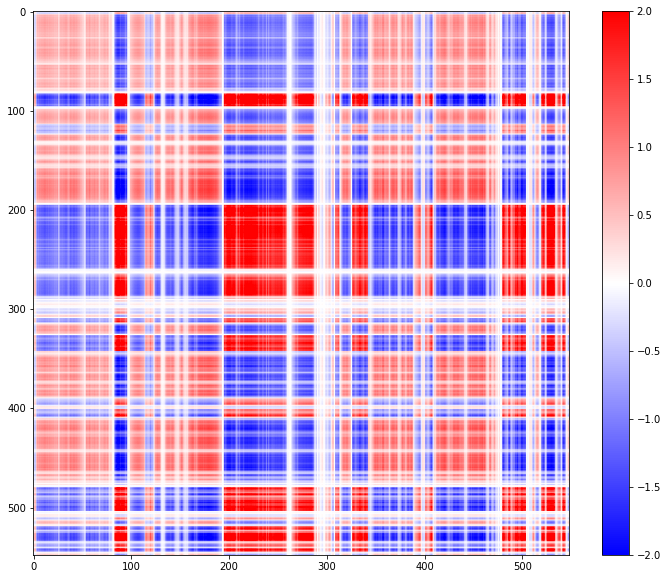

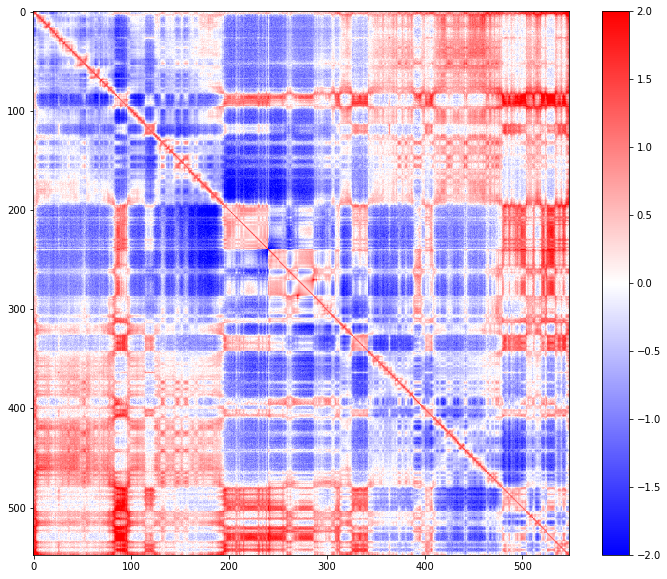

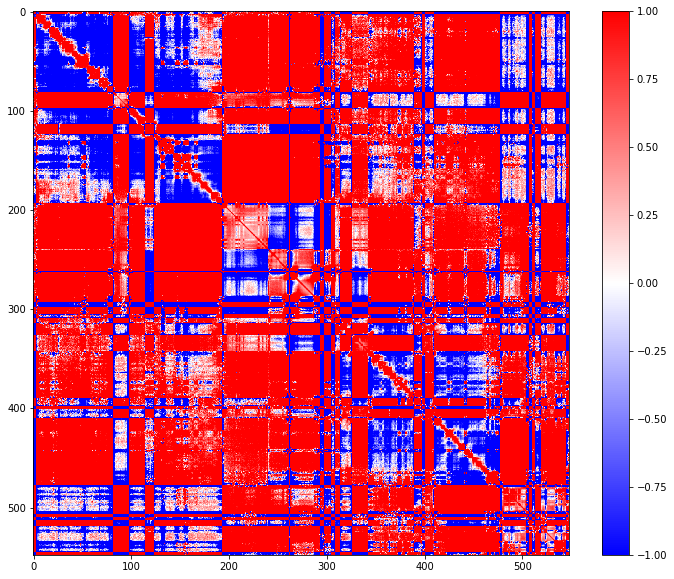

In [28]:
k=0
jkl = np.dot(U[:, k:k+1], E[:, k:k+1].T)
plt.figure(4, figsize = (12, 10))
plt.imshow(jkl*2
                ,aspect='auto',cmap='bwr'
              ,interpolation='None', vmin = -2, vmax = 2)
plt.colorbar();

plt.figure(3, figsize = (12, 10))
plt.imshow(enrich
                ,aspect='auto',cmap='bwr'
              ,interpolation='None', vmin = -2, vmax = 2)
plt.colorbar();

plt.figure(5, figsize = (12, 10))
plt.imshow(enrich/jkl
                ,aspect='auto',cmap='bwr'
              ,interpolation='None', vmin = -1, vmax = 1)
plt.colorbar();

### Relationship of enrichment vs eigenvector

Text(0, 0.5, 'Enrichment value')

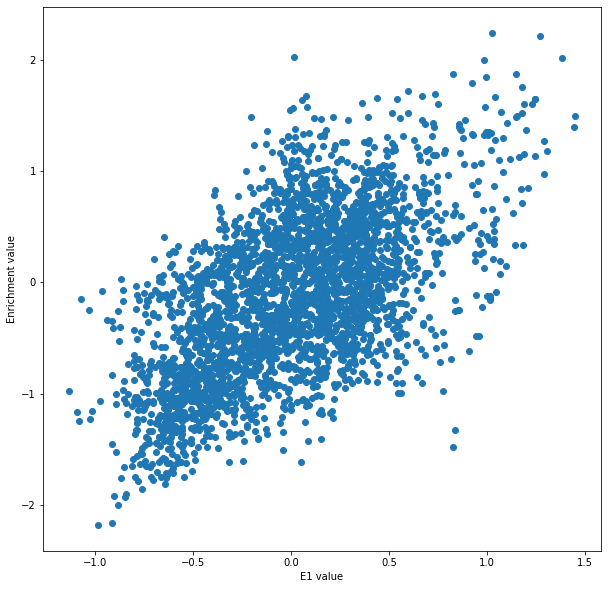

In [29]:
plt.figure(figsize= (10, 10))
plt.scatter(jkl.reshape(-1,1)[::100], enrich.reshape(-1,1)[::100])
plt.xlabel('E1 value')
plt.ylabel('Enrichment value')